In [57]:
import os
import time
import pandas as pd
import numpy as np
import numpy.random as npr
import copy
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma

In [59]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[.,!?;:\'\"\-]", " ", text)
    words = text.split()

    return [w.strip() for w in words if w.strip()]

def create_BoW_representation(doc_words, vocab_dict):
    word_counts = Counter(word for word in doc_words if word in vocab_dict)
    BoW_entries = []
    for word, count in word_counts.items():
        word_idx = vocab_dict[word]
        BoW_entries.append(f"{word_idx}:{count}")
    BoW_entries.sort(key=lambda x: int(x.split(":")[0]))

    return f"{len(BoW_entries)} {" ".join(BoW_entries)}"

def process_documents(input_file, vocab_file):
    with open(vocab_file, "r") as f:
        vocab = [line.strip() for line in f.readlines()]
    vocab_dict = {word: idx for idx, word in enumerate(vocab)}

    with open(input_file, "r") as f:
        content = f.read()

    docs = re.findall(r"<TEXT>\n(.*?)\n </TEXT", content, re.DOTALL)
    BoW_representations = []
    for doc in tqdm(docs):
        words = clean_text(doc)
        BoW = create_BoW_representation(words, vocab_dict)
        BoW_representations.append(BoW)

    return BoW_representations

def log_sum_exp(vec):
    vec_max = np.max(vec, axis=0)
    exp_vec = np.exp(vec - vec_max)
    sum_exp_vec = np.sum(exp_vec)
    log_sum_exp = np.log(sum_exp_vec) + vec_max
    return log_sum_exp

In [27]:
AP_BoW = process_documents("ap.txt", "vocab.txt")

100%|██████████| 2246/2246 [00:00<00:00, 3679.84it/s]


In [89]:
def load_documents():
    with open("vocab.txt", "r") as file:
        raw_lines = file.readlines()
    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    with open("ap_bow.txt", "r") as file:
        raw_lines = file.readlines()
        N = len(raw_lines)
    documents = np.zeros((N, V))
    nonzero_idxs = []

    for i in tqdm(range(N)):
        split = raw_lines[i].split(" ")
        M = int(split[0])
        split = split[1:]
        document = np.zeros((V,))
        nonzero_idx = []
        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(":")
            nonzero_idx.append(int(word_idx))
            document[int(word_idx)] = count

        try:
            assert(len(nonzero_idx) == M)
        except:
            raise AssertionError(f"{len(nonzero_idx)}, {M}")

        documents[i] = document
        nonzero_idxs.append(sorted(nonzero_idx))
    
    return idx_to_words, documents, nonzero_idxs

def init_variational_params(documents, K):
    N, V = documents.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for document in documents:
        M = np.sum((document > 0).astype("int32"))
        document_PHI = np.ones((M, K))
        document_PHI = document_PHI / K
        PHI.append(document_PHI)

    return LAMBDA, GAMMA, PHI

idx_to_words, documents, nonzero_idxs = load_documents()
K = 30
V = len(idx_to_words)
ETA = 100 / V
ALPHA = 1 / K

100%|██████████| 2246/2246 [00:00<00:00, 5607.64it/s]


In [98]:
LAMBDA, GAMMA, PHI = init_variational_params(documents, K)

In [93]:
E_log_p_BETA = np.sum((ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
E_log_p_BETA

np.float64(4124499.997307879)

In [120]:
np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1))

np.float64(-160043.30952025932)

In [121]:
N, _ = documents.shape 
E_log_q_THETA = 0
for i in range(N):
    E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
        - np.sum((GAMMA[i]-1) * (digamma(GAMMA[i])-digamma(np.sum(GAMMA[i]))))
E_log_q_THETA

np.float64(-160043.30952026162)

In [ ]:
def compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K):
    ELBO = 0
    N, _ = documents.shape

    E_log_p_BETA = np.sum((ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum((ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))
    ELBO += E_log_p_THETA

    E_log_p_x_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_p_x_z += document[idx] * np.sum(PHI[i][word_idx] * (digamma(GAMMA[i])-digamma(np.sum(GAMMA[i])))) \
                + document[idx] * np.sum(PHI[i][word_idx] * (digamma(LAMBDA[:, idx])-digamma(np.sum(LAMBDA, axis=1))))
            word_idx += 1
    ELBO += E_log_p_x_z

    E_log_q_BETA = np.sum(-loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_BETA

    E_log_q_THETA = np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_THETA

    E_log_q_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -document[idx] * np.sum(PHI[i][word_idx] * np.log(PHI[i][word_idx]))
            word_idx += 1
    ELBO += E_log_q_z

    return ELBO

In [58]:
LAMBDA, GAMMA, PHI = init_variational_params(articles, K)
compute_ELBO(LAMBDA, GAMMA, PHI, articles, nonzero_idxs, K)

np.float64(-5393263.209021693)

In [60]:
LAMBDA_t = copy.deepcopy(LAMBDA)
GAMMA_t = copy.deepcopy(GAMMA)
PHI_t = copy.deepcopy(PHI)

N, V = documents.shape
ELBOs = []
for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
    document = documents[i]
    nonzero_idx = nonzero_idxs[i]
    GAMMA_i_t = copy.deepcopy(GAMMA_t[i])
    corr_idx = 0
    for idx in nonzero_idx:
        log_PHI_ij = np.zeros((K,))
        for k in range(K):
            LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k])
            exp_propto = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t)) + digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
            log_PHI_ij[k] = exp_propto
        PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
        PHI_t[i][corr_idx] = PHI_ij
        corr_idx += 1
    GAMMA_i_t = np.zeros((K,)) + ALPHA
    for k in range(K):
        GAMMA_i_t[k] += np.sum(document[nonzero_idx] * PHI_t[i][:, k])
    GAMMA_t[i] = GAMMA_i_t

100%|██████████| 2246/2246 [04:59<00:00,  7.51it/s]


In [61]:
for k in tqdm(range(K), desc="Updating LAMBDA"):
    LAMBDA_k_t = np.zeros((V,)) + ETA
    for i in range(N):
        article = articles[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            LAMBDA_k_t[idx] += article[idx] * PHI_t[i][corr_idx][k]
            corr_idx += 1
        LAMBDA_t[k] = LAMBDA_k_t

compute_ELBO(LAMBDA_t, GAMMA_t, PHI_t, articles, nonzero_idxs, K)

100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


np.float64(-2860507.912042409)

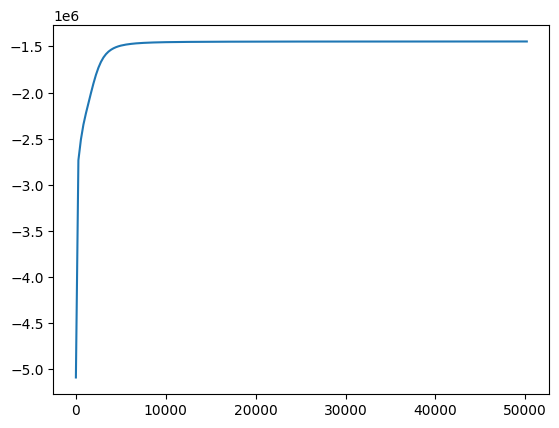

In [70]:
df = pd.read_csv("ELBO_V_10000.csv")
plt.plot(df["time_iter"], df["ELBO"])